### VGG 16 

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [123]:
path = '/Users/catherinecho/Downloads/crack_detection/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

In [124]:
path_Positive

'/Users/catherinecho/Downloads/crack_detection/1/*.jpg'

Text(0.5, 1.0, 'Negative and Positive')

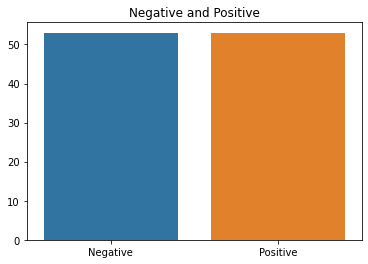

In [125]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [20]:
labels_y_data = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File').astype(str)
labels_y_data = pd.Series(labels_y_data, name='Result')
combined_data = pd.concat([file_Path, labels_y_data], axis=1)
combined_data = combined_data.sample(frac=1).reset_index(drop=True)
combined_data.head()

,File,Result
0,/Users/catherinecho/Downloads/crack_detection/...,0
1,/Users/catherinecho/Downloads/crack_detection/...,0
2,/Users/catherinecho/Downloads/crack_detection/...,1
3,/Users/catherinecho/Downloads/crack_detection/...,0
4,/Users/catherinecho/Downloads/crack_detection/...,1


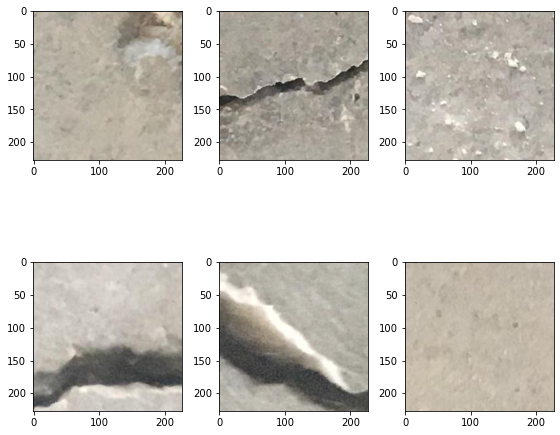

In [21]:
col = 3
row = 2
fig= plt.figure(figsize = (8,8))
for i in range(1, col * row +1):
    fig.add_subplot(row, col, i)
    plt.tight_layout()
    plt.imshow(plt.imread(combined_data.File[i]))

In [22]:
train_df, test_df = train_test_split(combined_data, test_size=0.2, random_state=42)

In [24]:
vgg_preprocessed = preprocess_input

In [129]:
train_data = ImageDataGenerator(preprocessing_function= vgg_preprocessed,validation_split=0.2)
test_data = ImageDataGenerator(preprocessing_function=vgg_preprocessed)

In [28]:
train_generator = train_data.flow_from_dataframe(
        dataframe=train_df,
        x_col='File',
        y_col='Result',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42)

Found 32000 validated image filenames belonging to 2 classes.


In [37]:
test_gen = test_data.flow_from_dataframe(
        dataframe=test_df,
        x_col='File',
        y_col='Result',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False)

Found 8000 validated image filenames belonging to 2 classes.


In [31]:
valid_gen = train_data.flow_from_dataframe(
        dataframe=train_df,
        x_col='File',
        y_col='Result',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42)

Found 32000 validated image filenames belonging to 2 classes.


In [32]:
pre_model = VGG16(input_shape=(100,100, 3),include_top=False, weights='imagenet', pooling='avg')
pre_model.trainable = False

In [27]:
x = Dense(64, activation='relu')(pre_model.output)
x = Dense(64, activation='relu')(x)
final_output = Dense(2, activation='softmax')(x)

In [28]:
model = Model(inputs=pre_model.input, outputs= final_output)
model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [29]:
callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]

In [32]:
history = model.fit(
    train_generator,
    validation_data=valid_gen,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
500/500 [==============================] - 4332s 9s/step - loss: 0.1284 - accuracy: 0.9569 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 2/25
500/500 [==============================] - 4699s 9s/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 3/25
500/500 [==============================] - 4065s 8s/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 4/25
500/500 [==============================] - 2958s 6s/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 5/25
500/500 [==============================] - 2935s 6s/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 6/25
500/500 [==============================] - 2892s 6s/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 7/25
500/500 [==============================] - 2899s 6s/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 7.5021e-04 - val_accur

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

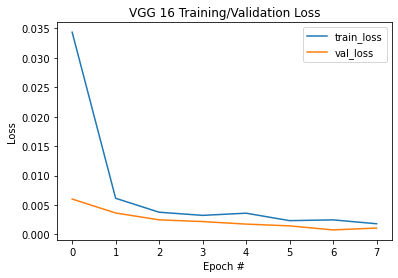

In [7]:
# plt.style.use("ggplot")
# plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("VGG 16 Training/Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

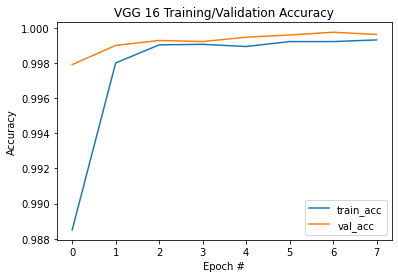

In [6]:
# plt.style.use("ggplot")
# plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("VGG 16 Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
model.save('VGG16_crack_detection_v1.h5')

In [37]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history_vgg16_v1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index = False)

In [3]:
history = pd.read_csv("history_vgg16_v1.csv")
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.034362,0.988500,0.005999,0.997906
1,0.006130,0.998000,0.003630,0.999000
2,0.003757,0.999031,0.002461,0.999281
3,0.003225,0.999062,0.002169,0.999219
4,0.003593,0.998937,0.001739,0.999469


In [43]:
loss,accuracy = model.evaluate(test_gen, verbose = 0)

In [42]:
print(f'The loss of this VGG16 is {loss:.3f}, and the accuracy is {(accuracy*100):.3f}%')

The loss of this VGG16 is 0.012, and the accuracy is 99.775%


#### Load the save model and compare the test accuracy with augmented datasets

In [13]:
from tensorflow import keras
model = keras.models.load_model('VGG16_crack_detection_v1.h5')

##### Load augmented dataset as Pytorch object

In [39]:
import torch
augmented_test =torch.load("small_1000_set.pth")

In [94]:
augmented_test[0].shape

torch.Size([1000, 3, 227, 227])

##### Convert loaded Pytorch object into images 

In [113]:
from torchvision.utils import save_image
import torch
import torchvision

# tensor= torch.rand(2, 3, 400, 711) 
i= 1
for index,img in enumerate(augmented_test[0]):
    result = int(augmented_test[1][index])
    str_i = str(i)
    i = i+1
    if result == 0 :
        path = './Negative/'+'img_' + str_i + '.png'
        save_image(img, path)
    else:
        path = './Positive/'+'img_' + str_i + '.png'
        save_image(img, path)

In [119]:
path = '/Users/catherinecho/Downloads/new_crack_detection/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

In [120]:
path_Positive

'/Users/catherinecho/Downloads/new_crack_detection/Positive/*.jpg'

Text(0.5, 1.0, 'Negative and Positive')

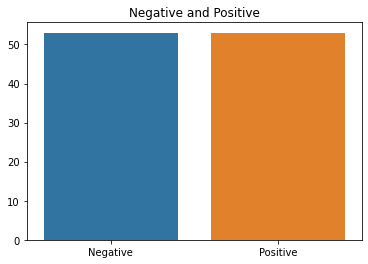

In [126]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [127]:
labels_y_data = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File').astype(str)
labels_y_data = pd.Series(labels_y_data, name='Result')
combined_data = pd.concat([file_Path, labels_y_data], axis=1)
combined_data = combined_data.sample(frac=1).reset_index(drop=True)
combined_data.head()

,File,Result
0,/Users/catherinecho/Downloads/crack_detection/...,0
1,/Users/catherinecho/Downloads/crack_detection/...,1
2,/Users/catherinecho/Downloads/crack_detection/...,0
3,/Users/catherinecho/Downloads/crack_detection/...,0
4,/Users/catherinecho/Downloads/crack_detection/...,0


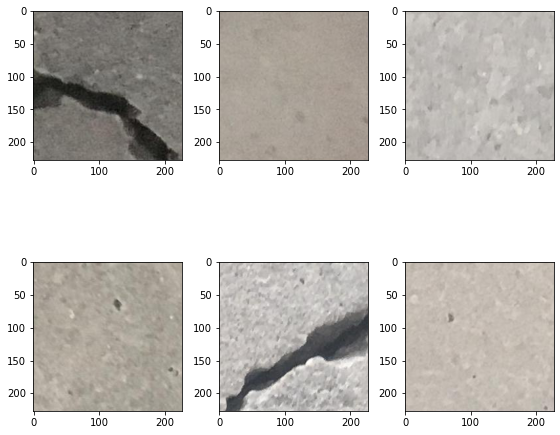

In [128]:
col = 3
row = 2
fig= plt.figure(figsize = (8,8))
for i in range(1, col * row +1):
    fig.add_subplot(row, col, i)
    plt.tight_layout()
    plt.imshow(plt.imread(combined_data.File[i]))

In [130]:
test_gen = test_data.flow_from_dataframe(
        dataframe=combined_data,
        x_col='File',
        y_col='Result',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False)

Found 40000 validated image filenames belonging to 2 classes.


In [132]:
loss,accuracy = model.evaluate(test_gen, verbose = 0)

In [133]:
print(f'The loss of this VGG16 is {loss:.3f}, and the accuracy is {(accuracy*100):.3f}%')

The loss of this VGG16 is 0.003, and the accuracy is 99.925%
